# Critical Component Identification in Distributed Publish-Subscribe Systems
## A Comprehensive Graph-Based Approach with Topological Metrics

**Author:** Ibrahim Onuralp Yigit  
**Date:** October 2025

---

### Abstract

This notebook demonstrates a comprehensive methodology for identifying critical components in distributed publish-subscribe (pub-sub) systems. Our approach combines:

1. **Multi-layer graph modeling** capturing applications, topics, brokers, and infrastructure
2. **QoS-aware component analysis** for determining component importance
3. **Topological metrics** for computing composite criticality scores
4. **Validation techniques** to ensure accuracy

**Key Innovation:** We use purely topological metrics (betweenness centrality, articulation points, reachability impact) to compute composite criticality scores, while QoS policies inform component importance without directly influencing the criticality calculation.

### Composite Criticality Score Definition

For any vertex $v \in V$, we define:

$$C_{\text{score}}(v) = \alpha \cdot C_B^{\text{norm}}(v) + \beta \cdot AP(v) + \gamma \cdot I(v)$$

Where:
- $C_B^{\text{norm}}(v) \in [0,1]$ is the normalized betweenness centrality
- $AP(v) \in \{0,1\}$ indicates if $v$ is an articulation point
- $I(v) \in [0,1]$ is the impact score measuring reachability loss
- $\alpha, \beta, \gamma$ are weight parameters (default: $\alpha=0.4, \beta=0.3, \gamma=0.3$)

The impact score is formally defined as:

$$I(v) = 1 - \frac{|R(G-v)|}{|R(G)|}$$

where $R(G)$ represents the set of all reachable vertex pairs in graph $G$.

## 1. Setup and Imports

In [1]:
# Standard library imports
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Tuple, Set
from dataclasses import dataclass
import warnings
warnings.filterwarnings('ignore')

# Graph analysis
import networkx as nx
from networkx.algorithms import community

# Visualization
from matplotlib.patches import FancyBboxPatch
import matplotlib.patches as mpatches

# Set style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("✓ All imports successful")
print(f"NetworkX version: {nx.__version__}")

✓ All imports successful
NetworkX version: 3.4.2


## 2. Multi-Layer Graph Model

### 2.1 Graph Structure Definition

We represent the distributed pub-sub system as a directed graph $G = (V, E)$ with four node types:

1. **Application (A)**: Publishers and subscribers
2. **Topic (T)**: Message channels with QoS policies
3. **Broker (B)**: Message routing infrastructure
4. **Node (N)**: Physical/virtual machines

**Edge types:**
- `PUBLISHES_TO`: Application → Topic
- `SUBSCRIBES_TO`: Application → Topic
- `ROUTES`: Broker → Topic
- `RUNS_ON`: Application/Broker → Node
- `DEPENDS_ON`: Application → Application
- `CONNECTS_TO`: Node → Node

In [2]:
@dataclass
class QoSPolicy:
    """Quality of Service policies for topics"""
    durability: str  # VOLATILE, TRANSIENT_LOCAL, TRANSIENT, PERSISTENT
    reliability: str  # BEST_EFFORT, RELIABLE
    transport_priority: str  # LOW, MEDIUM, HIGH, URGENT
    deadline_ms: float
    lifespan_ms: float
    history_depth: int

@dataclass
class TopologicalMetrics:
    """Topological metrics for criticality assessment"""
    betweenness_centrality_norm: float  # C_B^norm(v) ∈ [0,1]
    is_articulation_point: bool  # AP(v) ∈ {0,1}
    impact_score: float  # I(v) ∈ [0,1]
    composite_score: float  # C_score(v)

# Node type colors for visualization
NODE_COLORS = {
    'Application': '#3498db',  # Blue
    'Topic': '#2ecc71',  # Green
    'Broker': '#e74c3c',  # Red
    'Node': '#95a5a6'  # Gray
}

print("✓ Data structures defined")

✓ Data structures defined


## 3. Synthetic Dataset Generation

### 3.1 Generate a realistic pub-sub system

In [ ]:
def generate_synthetic_pubsub_system(
    num_nodes: int = 4,
    num_brokers: int = 2,
    num_applications: int = 20,
    num_topics: int = 30,
    seed: int = 42
) -> Dict:
    """
    Generate a synthetic publish-subscribe system with realistic characteristics
    """
    np.random.seed(seed)
    
    dataset = {
        'nodes': [],
        'brokers': [],
        'applications': [],
        'topics': [],
        'relationships': []
    }
    
    # 1. Generate physical nodes
    for i in range(1, num_nodes + 1):
        dataset['nodes'].append({
            'id': f'Node{i}',
            'name': f'Node{i}',
            'cpu_capacity': np.random.randint(4, 32),
            'memory_gb': np.random.choice([8, 16, 32, 64]),
            'network_bandwidth_mbps': np.random.choice([1000, 10000])
        })
    
    # 2. Generate brokers
    for i in range(1, num_brokers + 1):
        broker_node = f'Node{np.random.randint(1, num_nodes + 1)}'
        dataset['brokers'].append({
            'id': f'Broker{i}',
            'name': f'Broker{i}',
            'runs_on': broker_node,
            'max_topics': np.random.randint(50, 200)
        })
    
    # 3. Generate topics with QoS policies
    topic_domains = ['payment', 'order', 'metrics', 'notification', 'user', 'system']
    for i in range(1, num_topics + 1):
        domain = np.random.choice(topic_domains)
        
        # Domain-specific QoS
        if domain in ['payment', 'order']:
            durability = np.random.choice(['TRANSIENT', 'PERSISTENT'])
            reliability = 'RELIABLE'
            priority = np.random.choice(['HIGH', 'URGENT'])
            deadline = float(np.random.randint(10, 500))
        elif domain == 'metrics':
            durability = np.random.choice(['VOLATILE', 'TRANSIENT_LOCAL'])
            reliability = 'BEST_EFFORT'
            priority = 'LOW'
            deadline = float(np.random.randint(500, 2000))
        else:
            durability = np.random.choice(['VOLATILE', 'TRANSIENT_LOCAL', 'TRANSIENT', 'PERSISTENT'])
            reliability = np.random.choice(['BEST_EFFORT', 'RELIABLE'])
            priority = np.random.choice(['LOW', 'MEDIUM', 'HIGH'])
            deadline = float(np.random.randint(100, 1000))
        
        broker = f"Broker{np.random.randint(1, num_brokers + 1)}"
        
        dataset['topics'].append({
            'id': f'T{i}',
            'name': f'{domain}/topic_{i}',
            'broker': broker,
            'qos': {
                'durability': durability,
                'reliability': reliability,
                'transport_priority': priority,
                'deadline_ms': deadline,
                'lifespan_ms': float(np.random.randint(1000, 60000)),
                'history_depth': int(np.random.randint(1, 100))
            }
        })
    
    # 4. Generate applications
    app_types = ['API', 'Worker', 'Service', 'Gateway', 'Aggregator', 'Processor']
    for i in range(1, num_applications + 1):
        app_type = np.random.choice(app_types)
        node = f'Node{np.random.randint(1, num_nodes + 1)}'
        
        dataset['applications'].append({
            'id': f'App{i}',
            'name': f'{app_type}{i}',
            'type': app_type,
            'runs_on': node,
            'cpu_usage': float(np.random.uniform(0.1, 0.8)),
            'memory_mb': int(np.random.randint(128, 4096))
        })
    
    return dataset

# Generate dataset
dataset = generate_synthetic_pubsub_system(
    num_nodes=4,
    num_brokers=2,
    num_applications=20,
    num_topics=25
)

print("✓ Synthetic dataset generated")
print(f"  - Nodes: {len(dataset['nodes'])}")
print(f"  - Brokers: {len(dataset['brokers'])}")
print(f"  - Applications: {len(dataset['applications'])}")
print(f"  - Topics: {len(dataset['topics'])}")

✓ Synthetic dataset generated
  - Nodes: 10
  - Brokers: 5
  - Applications: 100
  - Topics: 200


## 4. Graph Construction

### 4.1 Build the multi-layer dependency graph

In [4]:
def build_graph_from_dataset(dataset: Dict) -> nx.DiGraph:
    """
    Construct a NetworkX directed graph from the dataset
    """
    G = nx.DiGraph()
    
    # Add nodes (physical infrastructure)
    for node in dataset['nodes']:
        G.add_node(
            node['id'],
            type='Node',
            name=node['name'],
            cpu_capacity=node['cpu_capacity'],
            memory_gb=node['memory_gb']
        )
    
    # Add brokers
    for broker in dataset['brokers']:
        G.add_node(
            broker['id'],
            type='Broker',
            name=broker['name'],
            max_topics=broker['max_topics']
        )
        # RUNS_ON relationship
        G.add_edge(broker['id'], broker['runs_on'], type='RUNS_ON')
    
    # Add topics
    for topic in dataset['topics']:
        qos = topic['qos']
        G.add_node(
            topic['id'],
            type='Topic',
            name=topic['name'],
            durability=qos['durability'],
            reliability=qos['reliability'],
            transport_priority=qos['transport_priority'],
            deadline_ms=qos['deadline_ms'],
            lifespan_ms=qos['lifespan_ms'],
            history_depth=qos['history_depth']
        )
        # ROUTES relationship
        G.add_edge(topic['broker'], topic['id'], type='ROUTES')
    
    # Add applications
    for app in dataset['applications']:
        G.add_node(
            app['id'],
            type='Application',
            name=app['name'],
            app_type=app['type'],
            cpu_usage=app['cpu_usage'],
            memory_mb=app['memory_mb']
        )
        # RUNS_ON relationship
        G.add_edge(app['id'], app['runs_on'], type='RUNS_ON')
    
    # Create PUBLISHES_TO relationships (each app publishes to 1-4 topics)
    for app in dataset['applications']:
        num_pubs = np.random.randint(1, 5)
        pub_topics = np.random.choice([t['id'] for t in dataset['topics']], num_pubs, replace=False)
        for topic in pub_topics:
            G.add_edge(app['id'], topic, type='PUBLISHES_TO')
    
    # Create SUBSCRIBES_TO relationships (each app subscribes to 2-6 topics)
    for app in dataset['applications']:
        num_subs = np.random.randint(2, 7)
        sub_topics = np.random.choice([t['id'] for t in dataset['topics']], num_subs, replace=False)
        for topic in sub_topics:
            G.add_edge(app['id'], topic, type='SUBSCRIBES_TO')
    
    # Create DEPENDS_ON relationships (application dependencies via pub-sub)
    apps = [app['id'] for app in dataset['applications']]
    for app1 in apps:
        # Find topics this app publishes to
        published_topics = [n for n in G.successors(app1) 
                           if G.nodes[n]['type'] == 'Topic' and 
                           G.edges[app1, n]['type'] == 'PUBLISHES_TO']
        
        for topic in published_topics:
            # Find apps that subscribe to these topics
            subscribers = [n for n in G.predecessors(topic) 
                          if G.nodes[n]['type'] == 'Application' and 
                          G.edges[n, topic]['type'] == 'SUBSCRIBES_TO']
            
            for app2 in subscribers:
                if app1 != app2:
                    G.add_edge(app2, app1, type='DEPENDS_ON')  # app2 depends on app1
    
    # Create CONNECTS_TO relationships (node connectivity)
    nodes = [n['id'] for n in dataset['nodes']]
    for i, node1 in enumerate(nodes):
        for node2 in nodes[i+1:]:
            if np.random.random() > 0.3:  # 70% connection probability
                G.add_edge(node1, node2, type='CONNECTS_TO')
                G.add_edge(node2, node1, type='CONNECTS_TO')
    
    return G

# Build graph
G = build_graph_from_dataset(dataset)

print("✓ Graph constructed successfully")
print(f"  - Total vertices: {G.number_of_nodes()}")
print(f"  - Total edges: {G.number_of_edges()}")
print(f"  - Graph density: {nx.density(G):.4f}")
print(f"  - Is connected: {nx.is_weakly_connected(G)}")

✓ Graph constructed successfully
  - Total vertices: 315
  - Total edges: 1489
  - Graph density: 0.0151
  - Is connected: True


## 5. QoS-Aware Component Importance Analysis

### 5.1 Calculate QoS Scores for Component Importance

**Important Note:** QoS scores are used to determine component importance (topics, applications, infrastructure), but are **NOT directly included** in the composite criticality score calculation.

In [5]:
class QoSAnalyzer:
    """Analyze QoS policies to determine component importance"""
    
    def __init__(self, durability_weight=0.6, reliability_weight=0.4):
        self.durability_weight = durability_weight
        self.reliability_weight = reliability_weight
        
        # Policy importance mappings
        self.durability_scores = {
            'VOLATILE': 0.2,
            'TRANSIENT_LOCAL': 0.5,
            'TRANSIENT': 0.75,
            'PERSISTENT': 1.0
        }
        
        self.reliability_scores = {
            'BEST_EFFORT': 0.3,
            'RELIABLE': 1.0
        }
    
    def calculate_topic_importance(self, topic_data: Dict) -> float:
        """
        Calculate topic importance based on QoS policies
        Returns value in [0, 1]
        """
        durability = topic_data.get('durability', 'VOLATILE')
        reliability = topic_data.get('reliability', 'BEST_EFFORT')
        
        dur_score = self.durability_scores.get(durability, 0.2)
        rel_score = self.reliability_scores.get(reliability, 0.3)
        
        importance = (self.durability_weight * dur_score + 
                     self.reliability_weight * rel_score)
        
        return importance
    
    def calculate_application_importance(self, graph: nx.DiGraph, app_id: str) -> float:
        """
        Calculate application importance based on connected topics' QoS
        """
        # Get published topics
        published_topics = [n for n in graph.successors(app_id) 
                           if graph.nodes[n].get('type') == 'Topic' and
                           graph.edges[app_id, n].get('type') == 'PUBLISHES_TO']
        
        # Get subscribed topics
        subscribed_topics = [n for n in graph.successors(app_id)
                            if graph.nodes[n].get('type') == 'Topic' and
                            graph.edges[app_id, n].get('type') == 'SUBSCRIBES_TO']
        
        # Calculate average importance
        pub_importance = [self.calculate_topic_importance(graph.nodes[t]) 
                         for t in published_topics] or [0.5]
        sub_importance = [self.calculate_topic_importance(graph.nodes[t]) 
                         for t in subscribed_topics] or [0.5]
        
        # Weighted average (publishers are more important)
        importance = 0.7 * np.mean(pub_importance) + 0.3 * np.mean(sub_importance)
        
        return importance
    
    def calculate_broker_importance(self, graph: nx.DiGraph, broker_id: str) -> float:
        """
        Calculate broker importance based on topics it routes
        """
        routed_topics = [n for n in graph.successors(broker_id) 
                        if graph.nodes[n].get('type') == 'Topic' and
                        graph.edges[broker_id, n].get('type') == 'ROUTES']
        
        topic_importance = [self.calculate_topic_importance(graph.nodes[t]) 
                           for t in routed_topics] or [0.5]
        
        importance = np.mean(topic_importance)
        
        return importance
    
    def calculate_node_importance(self, graph: nx.DiGraph, node_id: str) -> float:
        """
        Calculate node importance based on applications and brokers running on it
        """
        apps_on_node = [n for n in graph.predecessors(node_id) 
                       if graph.nodes[n].get('type') == 'Application' and
                       graph.edges[n, node_id].get('type') == 'RUNS_ON']
        
        brokers_on_node = [n for n in graph.predecessors(node_id) 
                         if graph.nodes[n].get('type') == 'Broker' and
                         graph.edges[n, node_id].get('type') == 'RUNS_ON']
        
        app_importance = [self.calculate_application_importance(graph, app) 
                         for app in apps_on_node] or [0.5]
        
        broker_importance = [self.calculate_broker_importance(graph, broker) 
                            for broker in brokers_on_node] or [0.5]
        
        importance = 0.6 * np.mean(app_importance) + 0.4 * np.mean(broker_importance)
        
        return importance

# Calculate QoS-based importance scores
qos_analyzer = QoSAnalyzer()

importance_scores = {}
for node in G.nodes():
    node_type = G.nodes[node].get('type')
    
    if node_type == 'Topic':
        importance_scores[node] = qos_analyzer.calculate_topic_importance(G.nodes[node])
    elif node_type == 'Application':
        importance_scores[node] = qos_analyzer.calculate_application_importance(G, node)
    else:
        importance_scores[node] = 0.5  # Default for nodes and brokers

# Add importance scores to graph
nx.set_node_attributes(G, importance_scores, 'qos_importance')

print("✓ QoS-based importance scores calculated")
print(f"  - Average topic importance: {np.mean([s for n, s in importance_scores.items() if G.nodes[n]['type'] == 'Topic']):.3f}")
print(f"  - Average app importance: {np.mean([s for n, s in importance_scores.items() if G.nodes[n]['type'] == 'Application']):.3f}")
print(f"  - Average broker importance: {np.mean([s for n, s in importance_scores.items() if G.nodes[n]['type'] == 'Broker']):.3f}")
print(f"  - Average node importance: {np.mean([s for n, s in importance_scores.items() if G.nodes[n]['type'] == 'Node']):.3f}")

✓ QoS-based importance scores calculated
  - Average topic importance: 0.690
  - Average app importance: 0.671
  - Average broker importance: 0.500
  - Average node importance: 0.500


## 6. Topological Metrics-Based Criticality Analysis

### 6.1 Compute Centrality Metrics

In [6]:
def compute_centrality_metrics(graph: nx.DiGraph) -> Dict:
    """
    Compute all centrality metrics for the graph
    """
    print("Computing centrality metrics...")
    
    # Betweenness centrality (normalized by default in NetworkX)
    betweenness = nx.betweenness_centrality(graph, normalized=True)
    
    # Degree centrality
    degree = nx.degree_centrality(graph)
    
    # Closeness centrality
    try:
        closeness = nx.closeness_centrality(graph)
    except:
        closeness = {node: 0 for node in graph.nodes()}
    
    # PageRank
    try:
        pagerank = nx.pagerank(graph, max_iter=100)
    except:
        pagerank = {node: 1.0/len(graph) for node in graph.nodes()}
    
    return {
        'betweenness': betweenness,
        'degree': degree,
        'closeness': closeness,
        'pagerank': pagerank
    }

# Compute centralities
centralities = compute_centrality_metrics(G)

print("✓ Centrality metrics computed")
print(f"  - Max betweenness: {max(centralities['betweenness'].values()):.4f}")
print(f"  - Avg betweenness: {np.mean(list(centralities['betweenness'].values())):.4f}")

Computing centrality metrics...
✓ Centrality metrics computed
  - Max betweenness: 0.0224
  - Avg betweenness: 0.0022


### 6.2 Identify Articulation Points

In [7]:
def find_articulation_points(graph: nx.DiGraph) -> Set[str]:
    """
    Find articulation points (cut vertices) in the graph
    """
    # Convert to undirected for articulation point detection
    undirected = graph.to_undirected()
    articulation_points = set(nx.articulation_points(undirected))
    
    return articulation_points

# Find articulation points
articulation_points = find_articulation_points(G)

print(f"✓ Found {len(articulation_points)} articulation points")
if articulation_points:
    print("  Articulation points:")
    for ap in list(articulation_points)[:10]:  # Show first 10
        node_type = G.nodes[ap]['type']
        node_name = G.nodes[ap]['name']
        print(f"    - {node_name} ({node_type})")

✓ Found 4 articulation points
  Articulation points:
    - Broker2 (Broker)
    - Broker1 (Broker)
    - Broker3 (Broker)
    - Broker5 (Broker)


### 6.3 Calculate Impact Scores (Reachability Loss)

This is the most computationally expensive step. We calculate:

$$I(v) = 1 - \frac{|R(G-v)|}{|R(G)|}$$

In [8]:
def count_reachable_pairs(graph: nx.DiGraph) -> int:
    """
    Count total reachable pairs |R(G)|
    """
    nodes = list(graph.nodes())
    reachable_count = 0
    
    for source in nodes:
        try:
            reachable = nx.descendants(graph, source)
            reachable_count += len(reachable)
        except:
            continue
    
    return reachable_count

def calculate_impact_scores(graph: nx.DiGraph, sample_size: int = 30) -> Dict[str, float]:
    """
    Calculate impact scores for nodes (sampled for performance)
    """
    print(f"Calculating impact scores (sampling {sample_size} nodes)...")
    
    # Calculate original reachability
    original_reachable = count_reachable_pairs(graph)
    
    if original_reachable == 0:
        return {node: 0.0 for node in graph.nodes()}
    
    impact_scores = {}
    
    # Sample nodes for analysis
    nodes = list(graph.nodes())
    if len(nodes) > sample_size:
        sampled_nodes = np.random.choice(nodes, sample_size, replace=False)
    else:
        sampled_nodes = nodes
    
    # Calculate impact for sampled nodes
    for i, node in enumerate(sampled_nodes):
        if (i + 1) % 10 == 0:
            print(f"  Progress: {i+1}/{len(sampled_nodes)}")
        
        # Create graph without this node
        test_graph = graph.copy()
        test_graph.remove_node(node)
        
        # Calculate new reachability
        new_reachable = count_reachable_pairs(test_graph)
        
        # Calculate impact
        impact_scores[node] = 1.0 - (new_reachable / original_reachable)
    
    # Estimate for non-sampled nodes using betweenness
    avg_impact = np.mean(list(impact_scores.values()))
    for node in graph.nodes():
        if node not in impact_scores:
            # Estimate based on betweenness centrality
            betweenness = centralities['betweenness'][node]
            impact_scores[node] = betweenness * avg_impact * 1.5
            impact_scores[node] = min(1.0, impact_scores[node])
    
    return impact_scores

# Calculate impact scores
impact_scores = calculate_impact_scores(G, sample_size=30)

print("✓ Impact scores calculated")
print(f"  - Max impact: {max(impact_scores.values()):.4f}")
print(f"  - Avg impact: {np.mean(list(impact_scores.values())):.4f}")

Calculating impact scores (sampling 30 nodes)...
  Progress: 10/30
  Progress: 20/30
  Progress: 30/30
✓ Impact scores calculated
  - Max impact: 0.0262
  - Avg impact: 0.0008


### 6.4 Calculate Composite Criticality Scores

Now we combine the three topological metrics:

$$C_{\text{score}}(v) = \alpha \cdot C_B^{\text{norm}}(v) + \beta \cdot AP(v) + \gamma \cdot I(v)$$

In [9]:
def calculate_composite_criticality(
    betweenness: float,
    is_articulation_point: bool,
    impact_score: float,
    alpha: float = 0.4,
    beta: float = 0.3,
    gamma: float = 0.3
) -> float:
    """
    Calculate composite criticality score
    
    Args:
        betweenness: Normalized betweenness centrality [0,1]
        is_articulation_point: Boolean indicator
        impact_score: Reachability loss score [0,1]
        alpha: Weight for betweenness (default: 0.4)
        beta: Weight for articulation point (default: 0.3)
        gamma: Weight for impact score (default: 0.3)
    
    Returns:
        Composite criticality score in [0, 1]
    """
    ap_value = 1.0 if is_articulation_point else 0.0
    
    score = alpha * betweenness + beta * ap_value + gamma * impact_score
    
    # Ensure score is in [0, 1]
    return min(1.0, max(0.0, score))

# Calculate composite scores for all nodes
composite_scores = {}

for node in G.nodes():
    betweenness = centralities['betweenness'][node]
    is_ap = node in articulation_points
    impact = impact_scores[node]
    
    composite_scores[node] = calculate_composite_criticality(
        betweenness=betweenness,
        is_articulation_point=is_ap,
        impact_score=impact
    )

# Add to graph
nx.set_node_attributes(G, centralities['betweenness'], 'betweenness_centrality')
nx.set_node_attributes(G, impact_scores, 'impact_score')
nx.set_node_attributes(G, {n: n in articulation_points for n in G.nodes()}, 'is_articulation_point')
nx.set_node_attributes(G, composite_scores, 'composite_criticality')

print("✓ Composite criticality scores calculated")
print(f"  - Max criticality: {max(composite_scores.values()):.4f}")
print(f"  - Avg criticality: {np.mean(list(composite_scores.values())):.4f}")

✓ Composite criticality scores calculated
  - Max criticality: 0.3005
  - Avg criticality: 0.0049


### 6.5 Criticality Classification

In [10]:
def calculate_criticality_level_thresholds_by_boxplot(composite_scores: Dict[str, float]) -> Dict[str, float]:
    """
    Calculate criticality level thresholds based on boxplot statistics
    """
    scores = list(composite_scores.values())
    q1 = np.percentile(scores, 25)
    q2 = np.percentile(scores, 50)
    q3 = np.percentile(scores, 75)
    
    iqr = q3 - q1
    lower_bound = max(0.0, q1 - 1.5 * iqr)
    upper_bound = min(1.0, q3 + 1.5 * iqr)
    
    thresholds = {
        'VERY_LOW': lower_bound,
        'LOW': q1,
        'MEDIUM': q2,
        'HIGH': q3,
        'CRITICAL': upper_bound
    }
    
    return thresholds

def classify_criticality(score: float, thresholds: Dict[str, float]) -> str: 
    """
    Classify criticality level based on thresholds
    """
    if score <= thresholds['LOW']:
        return 'VERY_LOW'
    elif score <= thresholds['MEDIUM']:
        return 'LOW'
    elif score <= thresholds['HIGH']:
        return 'MEDIUM'
    elif score <= thresholds['CRITICAL']:
        return 'HIGH'
    else:
        return 'CRITICAL'

# Criticality level thresholds
CRITICALITY_THRESHOLDS = calculate_criticality_level_thresholds_by_boxplot(composite_scores)

# Classify all nodes
criticality_levels = {node: classify_criticality(score, CRITICALITY_THRESHOLDS) 
                      for node, score in composite_scores.items()}

nx.set_node_attributes(G, criticality_levels, 'criticality_level')

# Create analysis DataFrame
analysis_df = pd.DataFrame([
    {
        'node': node,
        'name': G.nodes[node]['name'],
        'type': G.nodes[node]['type'],
        'betweenness': centralities['betweenness'][node],
        'is_articulation_point': node in articulation_points,
        'impact_score': impact_scores[node],
        'composite_criticality': composite_scores[node],
        'criticality_level': criticality_levels[node],
        'qos_importance': importance_scores.get(node, 0.5)
    }
    for node in G.nodes()
]).sort_values('composite_criticality', ascending=False)

print("\n" + "="*80)
print("CRITICALITY ANALYSIS SUMMARY")
print("="*80)

print("\nCriticality Level Distribution:")
print(analysis_df['criticality_level'].value_counts())

print("\nTop 10 Critical Components:")
print(analysis_df[['name', 'type', 'composite_criticality', 'criticality_level']].head(10).to_string(index=False))

print("\nArticulation Points by Type:")
ap_by_type = analysis_df[analysis_df['is_articulation_point']].groupby('type').size()
print(ap_by_type)


CRITICALITY ANALYSIS SUMMARY

Criticality Level Distribution:
criticality_level
VERY_LOW    189
CRITICAL     49
MEDIUM       47
HIGH         30
Name: count, dtype: int64

Top 10 Critical Components:
       name        type  composite_criticality criticality_level
    Broker3      Broker               0.300458          CRITICAL
    Broker1      Broker               0.300000          CRITICAL
    Broker2      Broker               0.300000          CRITICAL
    Broker5      Broker               0.300000          CRITICAL
      API76 Application               0.011703          CRITICAL
  Gateway69 Application               0.010699          CRITICAL
      API78 Application               0.010463          CRITICAL
  Service80 Application               0.010051          CRITICAL
   Worker33 Application               0.009024          CRITICAL
Processor64 Application               0.008218          CRITICAL

Articulation Points by Type:
type
Broker    4
dtype: int64


## 7. Visualization

### 7.1 Criticality Distribution

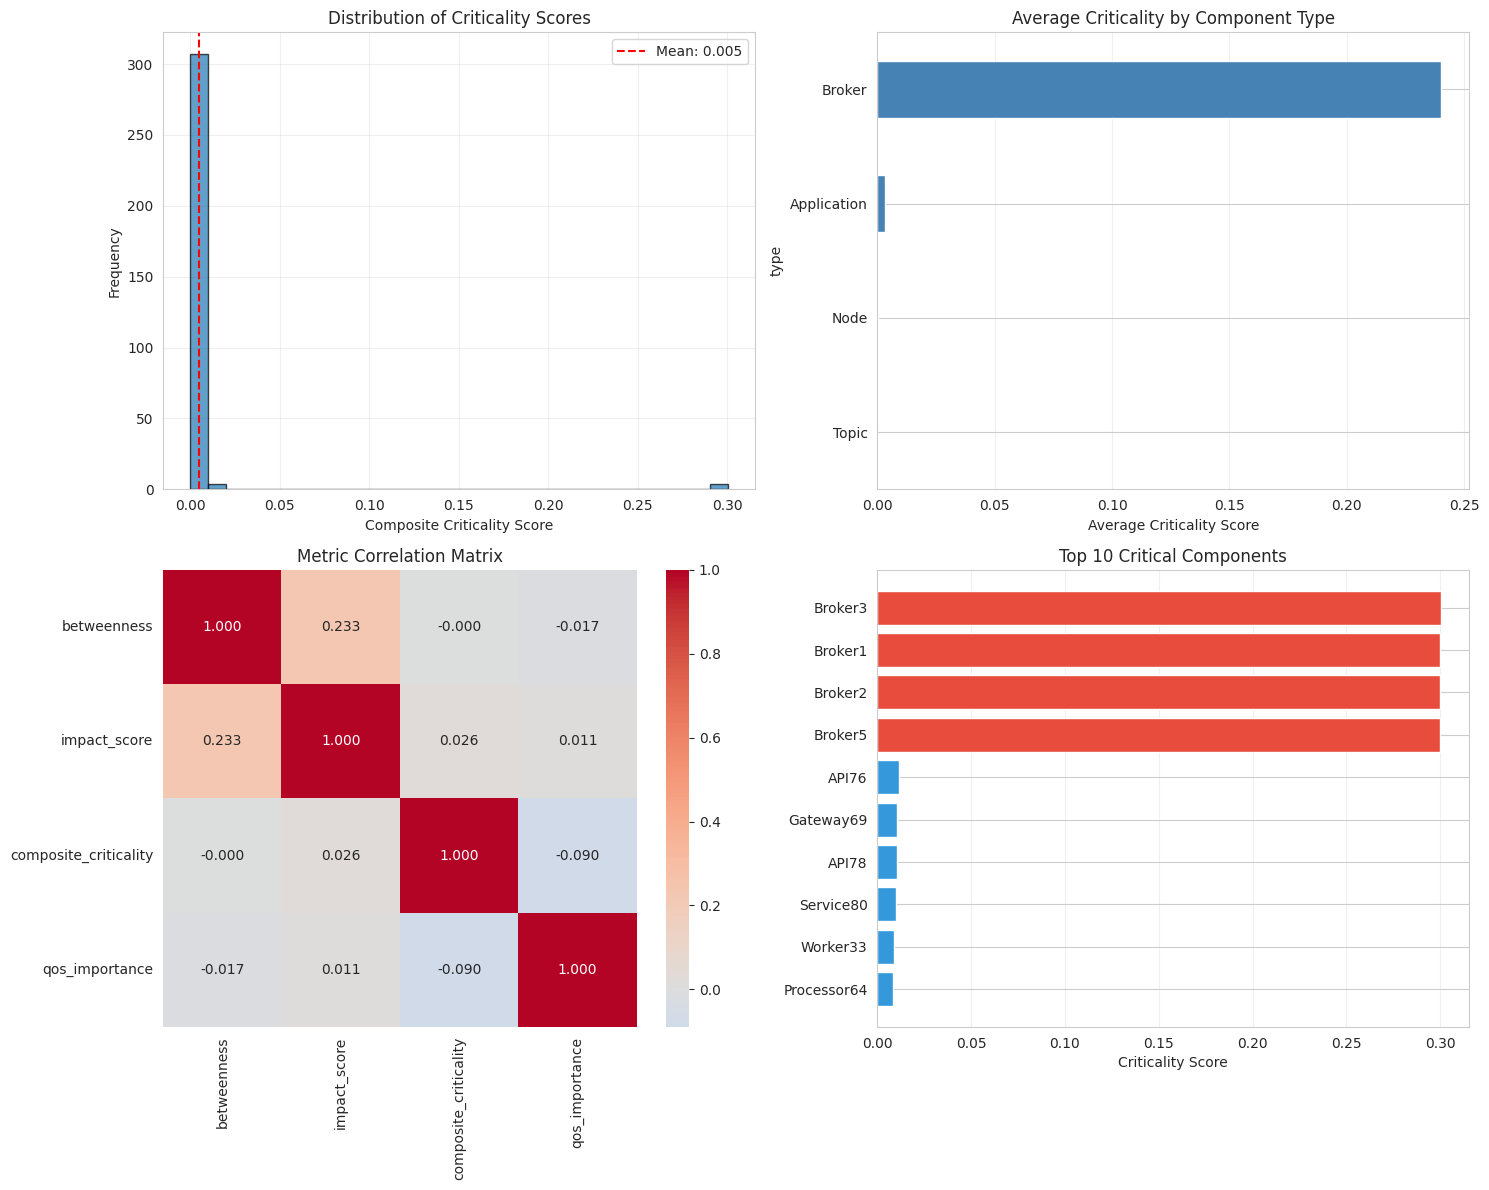

✓ Visualizations generated


In [11]:
fig, axes = plt.subplots(2, 2, figsize=(15, 12))

# 1. Criticality score distribution
ax = axes[0, 0]
ax.hist(analysis_df['composite_criticality'], bins=30, edgecolor='black', alpha=0.7)
ax.axvline(analysis_df['composite_criticality'].mean(), color='red', 
           linestyle='--', label=f'Mean: {analysis_df["composite_criticality"].mean():.3f}')
ax.set_xlabel('Composite Criticality Score')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of Criticality Scores')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Criticality by component type
ax = axes[0, 1]
type_data = analysis_df.groupby('type')['composite_criticality'].mean().sort_values()
type_data.plot(kind='barh', ax=ax, color='steelblue')
ax.set_xlabel('Average Criticality Score')
ax.set_title('Average Criticality by Component Type')
ax.grid(True, alpha=0.3, axis='x')

# 3. Metric correlation heatmap
ax = axes[1, 0]
metrics = ['betweenness', 'impact_score', 'composite_criticality', 'qos_importance']
corr_matrix = analysis_df[metrics].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.3f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('Metric Correlation Matrix')

# 4. Top critical components
ax = axes[1, 1]
top_10 = analysis_df.head(10)
colors = [NODE_COLORS[t] for t in top_10['type']]
ax.barh(range(len(top_10)), top_10['composite_criticality'], color=colors)
ax.set_yticks(range(len(top_10)))
ax.set_yticklabels(top_10['name'])
ax.set_xlabel('Criticality Score')
ax.set_title('Top 10 Critical Components')
ax.invert_yaxis()
ax.grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig('criticality_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualizations generated")

### 7.2 Graph Visualization with Criticality

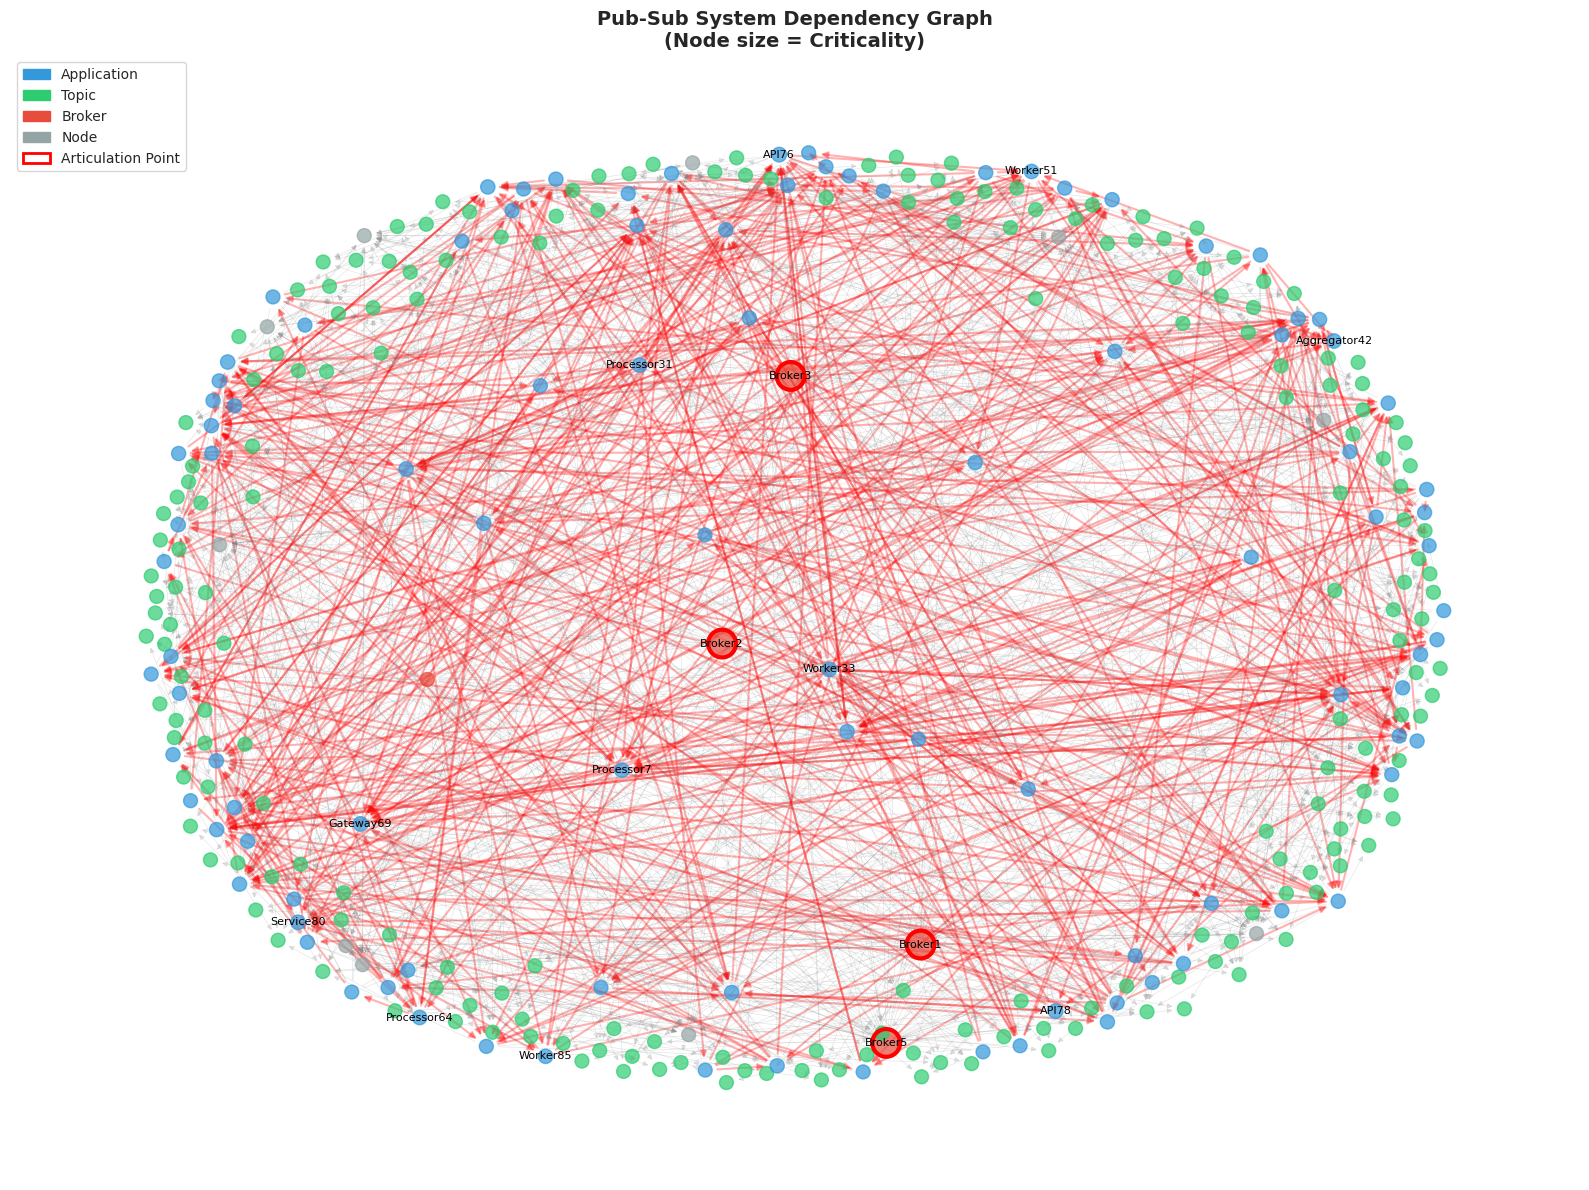

✓ Graph visualization complete


In [12]:
def visualize_graph_with_criticality(graph: nx.DiGraph, layout_type='spring'):
    """
    Visualize graph with node sizes based on criticality
    """
    fig, ax = plt.subplots(figsize=(16, 12))
    
    # Calculate layout
    if layout_type == 'spring':
        pos = nx.spring_layout(graph, k=2, iterations=50, seed=42)
    else:
        pos = nx.kamada_kawai_layout(graph)
    
    # Node sizes based on criticality
    node_sizes = [graph.nodes[node].get('composite_criticality', 0.1) * 1000 + 100 
                  for node in graph.nodes()]
    
    # Node colors based on type
    node_colors = [NODE_COLORS.get(graph.nodes[node]['type'], '#95a5a6') 
                   for node in graph.nodes()]
    
    # Draw nodes
    nx.draw_networkx_nodes(graph, pos, 
                          node_size=node_sizes,
                          node_color=node_colors,
                          alpha=0.7,
                          ax=ax)
    
    # Highlight articulation points with red border
    ap_nodes = [node for node in graph.nodes() 
                if graph.nodes[node].get('is_articulation_point', False)]
    if ap_nodes:
        ap_sizes = [graph.nodes[node].get('composite_criticality', 0.1) * 1000 + 100 
                   for node in ap_nodes]
        nx.draw_networkx_nodes(graph, pos, 
                              nodelist=ap_nodes,
                              node_size=ap_sizes,
                              node_color='none',
                              edgecolors='red',
                              linewidths=3,
                              ax=ax)
    
    # Draw edges with different styles for different types
    edge_types = set(nx.get_edge_attributes(graph, 'type').values())
    for edge_type in edge_types:
        edges = [(u, v) for u, v, d in graph.edges(data=True) if d.get('type') == edge_type]
        if edge_type == 'DEPENDS_ON':
            nx.draw_networkx_edges(graph, pos, edges, 
                                  edge_color='red', alpha=0.3, arrows=True,
                                  arrowsize=10, width=1.5, ax=ax)
        else:
            nx.draw_networkx_edges(graph, pos, edges,
                                  edge_color='gray', alpha=0.2, arrows=True,
                                  arrowsize=8, width=0.5, ax=ax)
    
    # Labels for top critical nodes
    top_critical = sorted(graph.nodes(), 
                         key=lambda n: graph.nodes[n].get('composite_criticality', 0),
                         reverse=True)[:15]
    labels = {node: graph.nodes[node]['name'] for node in top_critical}
    nx.draw_networkx_labels(graph, pos, labels, font_size=8, ax=ax)
    
    # Legend
    legend_elements = [
        mpatches.Patch(color=NODE_COLORS['Application'], label='Application'),
        mpatches.Patch(color=NODE_COLORS['Topic'], label='Topic'),
        mpatches.Patch(color=NODE_COLORS['Broker'], label='Broker'),
        mpatches.Patch(color=NODE_COLORS['Node'], label='Node'),
        mpatches.Patch(facecolor='white', edgecolor='red', linewidth=2, label='Articulation Point')
    ]
    ax.legend(handles=legend_elements, loc='upper left', fontsize=10)
    
    ax.set_title('Pub-Sub System Dependency Graph\n(Node size = Criticality)', 
                fontsize=14, fontweight='bold')
    ax.axis('off')
    
    plt.tight_layout()
    plt.savefig('graph_visualization.png', dpi=300, bbox_inches='tight')
    plt.show()

visualize_graph_with_criticality(G)
print("✓ Graph visualization complete")

## 8. Validation and Impact Analysis

### 8.1 Simulate Component Failures

In [13]:
def simulate_failure_impact(graph: nx.DiGraph, node_to_remove: str) -> Dict:
    """
    Simulate the impact of removing a component
    """
    original_graph = graph.copy()
    
    # Calculate original metrics
    original_components = nx.number_weakly_connected_components(original_graph)
    original_reachable = count_reachable_pairs(original_graph)
    
    # Remove node
    test_graph = graph.copy()
    test_graph.remove_node(node_to_remove)
    
    # Calculate new metrics
    new_components = nx.number_weakly_connected_components(test_graph)
    new_reachable = count_reachable_pairs(test_graph)
    
    # Find affected nodes
    affected_nodes = set()
    for node in test_graph.nodes():
        # Check if this node had path to/from removed node
        if nx.has_path(original_graph, node_to_remove, node) or \
           nx.has_path(original_graph, node, node_to_remove):
            # Check if path still exists through other nodes
            has_alternative = False
            for other in test_graph.nodes():
                if other != node and (nx.has_path(test_graph, other, node) or 
                                     nx.has_path(test_graph, node, other)):
                    has_alternative = True
                    break
            if not has_alternative:
                affected_nodes.add(node)
    
    return {
        'removed_node': node_to_remove,
        'node_type': graph.nodes[node_to_remove]['type'],
        'criticality_score': graph.nodes[node_to_remove].get('composite_criticality', 0),
        'component_increase': new_components - original_components,
        'reachability_loss': (original_reachable - new_reachable) / original_reachable if original_reachable > 0 else 0,
        'affected_nodes_count': len(affected_nodes),
        'affected_nodes': affected_nodes
    }

# Test failure impact for top 10 critical components
print("Simulating failure impacts for top critical components...\n")

failure_impacts = []
top_critical = analysis_df.head(10)['node'].tolist()

for node in top_critical:
    impact = simulate_failure_impact(G, node)
    failure_impacts.append(impact)
    
    print(f"Node: {G.nodes[node]['name']} ({impact['node_type']})")
    print(f"  Criticality Score: {impact['criticality_score']:.4f}")
    print(f"  Reachability Loss: {impact['reachability_loss']:.2%}")
    print(f"  Affected Nodes: {impact['affected_nodes_count']}")
    print(f"  Component Change: {impact['component_increase']:+d}")
    print()

# Create impact DataFrame
impact_df = pd.DataFrame(failure_impacts)
impact_df = impact_df.sort_values('reachability_loss', ascending=False)

print("✓ Failure impact simulation complete")

Simulating failure impacts for top critical components...

Node: Broker3 (Broker)
  Criticality Score: 0.3005
  Reachability Loss: 0.15%
  Affected Nodes: 1
  Component Change: +1

Node: Broker1 (Broker)
  Criticality Score: 0.3000
  Reachability Loss: 0.17%
  Affected Nodes: 2
  Component Change: +2

Node: Broker2 (Broker)
  Criticality Score: 0.3000
  Reachability Loss: 0.21%
  Affected Nodes: 1
  Component Change: +1

Node: Broker5 (Broker)
  Criticality Score: 0.3000
  Reachability Loss: 0.19%
  Affected Nodes: 2
  Component Change: +2

Node: API76 (Application)
  Criticality Score: 0.0117
  Reachability Loss: 1.99%
  Affected Nodes: 0
  Component Change: +0

Node: Gateway69 (Application)
  Criticality Score: 0.0107
  Reachability Loss: 1.34%
  Affected Nodes: 0
  Component Change: +0

Node: API78 (Application)
  Criticality Score: 0.0105
  Reachability Loss: 2.62%
  Affected Nodes: 0
  Component Change: +0

Node: Service80 (Application)
  Criticality Score: 0.0101
  Reachability L

### 8.2 Validation: Correlation Analysis

Correlation between Criticality Score and Actual Impact: -0.8986

This indicates strong correlation.


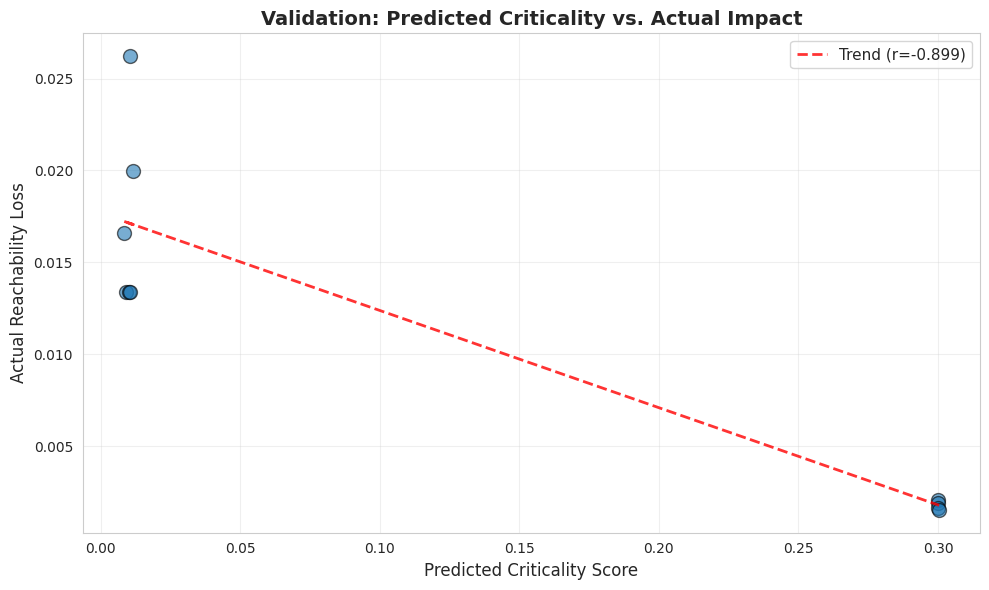

✓ Validation analysis complete


In [14]:
# Merge criticality scores with actual impact
validation_df = impact_df[['removed_node', 'criticality_score', 'reachability_loss']].copy()

# Calculate correlation
correlation = validation_df['criticality_score'].corr(validation_df['reachability_loss'])

print(f"Correlation between Criticality Score and Actual Impact: {correlation:.4f}")
print(f"\nThis indicates {'strong' if abs(correlation) > 0.7 else 'moderate' if abs(correlation) > 0.4 else 'weak'} correlation.")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(validation_df['criticality_score'], 
          validation_df['reachability_loss'],
          s=100, alpha=0.6, edgecolors='black')

# Add trend line
z = np.polyfit(validation_df['criticality_score'], validation_df['reachability_loss'], 1)
p = np.poly1d(z)
ax.plot(validation_df['criticality_score'], 
       p(validation_df['criticality_score']), 
       "r--", alpha=0.8, linewidth=2,
       label=f'Trend (r={correlation:.3f})')

ax.set_xlabel('Predicted Criticality Score', fontsize=12)
ax.set_ylabel('Actual Reachability Loss', fontsize=12)
ax.set_title('Validation: Predicted Criticality vs. Actual Impact', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('validation_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Validation analysis complete")

## 9. Summary Report

In [15]:
print("\n" + "="*80)
print("COMPREHENSIVE CRITICALITY ANALYSIS REPORT")
print("="*80)

print("\n1. SYSTEM OVERVIEW")
print("-" * 80)
print(f"Total Components: {G.number_of_nodes()}")
print(f"  - Nodes: {len([n for n in G.nodes() if G.nodes[n]['type'] == 'Node'])}")
print(f"  - Brokers: {len([n for n in G.nodes() if G.nodes[n]['type'] == 'Broker'])}")
print(f"  - Applications: {len([n for n in G.nodes() if G.nodes[n]['type'] == 'Application'])}")
print(f"  - Topics: {len([n for n in G.nodes() if G.nodes[n]['type'] == 'Topic'])}")
print(f"\nTotal Dependencies: {G.number_of_edges()}")
print(f"Graph Density: {nx.density(G):.4f}")
print(f"Is Connected: {nx.is_weakly_connected(G)}")

print("\n2. TOPOLOGICAL METRICS")
print("-" * 80)
print(f"Articulation Points: {len(articulation_points)}")
print(f"Max Betweenness Centrality: {max(centralities['betweenness'].values()):.4f}")
print(f"Average Impact Score: {np.mean(list(impact_scores.values())):.4f}")

print("\n3. CRITICALITY CLASSIFICATION")
print("-" * 80)
for level in ['CRITICAL', 'HIGH', 'MEDIUM', 'LOW', 'VERY_LOW']:
    count = (analysis_df['criticality_level'] == level).sum()
    percentage = count / len(analysis_df) * 100
    print(f"{level:12s}: {count:3d} components ({percentage:5.1f}%)")

print("\n4. TOP 10 CRITICAL COMPONENTS")
print("-" * 80)
print(analysis_df[['name', 'type', 'composite_criticality', 
                   'betweenness', 'impact_score', 'is_articulation_point']]
      .head(10).to_string(index=False))

print("\n5. VALIDATION RESULTS")
print("-" * 80)
print(f"Correlation (Predicted vs. Actual): {correlation:.4f}")
print(f"Average Reachability Loss (Top 10): {impact_df['reachability_loss'].mean():.2%}")

print("\n6. KEY FINDINGS")
print("-" * 80)

# Identify most critical component type
type_criticality = analysis_df.groupby('type')['composite_criticality'].mean().sort_values(ascending=False)
print(f"• Most critical component type: {type_criticality.index[0]} (avg: {type_criticality.iloc[0]:.4f})")

# Count high-risk components
high_risk = analysis_df[analysis_df['criticality_level'].isin(['HIGH', 'CRITICAL'])]
print(f"• High-risk components requiring attention: {len(high_risk)}")

# Articulation points by type
if len(articulation_points) > 0:
    ap_types = analysis_df[analysis_df['is_articulation_point']]['type'].value_counts()
    print(f"• Articulation points are primarily: {ap_types.index[0]}s ({ap_types.iloc[0]} instances)")

print("\n7. RECOMMENDATIONS")
print("-" * 80)
print("• Implement redundancy for high-criticality articulation points")
print("• Monitor components with impact scores > 0.5")
print(f"• Consider load balancing for {type_criticality.index[0]} layer")
print("• Establish fallback mechanisms for CRITICAL-level components")

print("\n" + "="*80)
print("END OF REPORT")
print("="*80)


COMPREHENSIVE CRITICALITY ANALYSIS REPORT

1. SYSTEM OVERVIEW
--------------------------------------------------------------------------------
Total Components: 315
  - Nodes: 10
  - Brokers: 5
  - Applications: 100
  - Topics: 200

Total Dependencies: 1489
Graph Density: 0.0151
Is Connected: True

2. TOPOLOGICAL METRICS
--------------------------------------------------------------------------------
Articulation Points: 4
Max Betweenness Centrality: 0.0224
Average Impact Score: 0.0008

3. CRITICALITY CLASSIFICATION
--------------------------------------------------------------------------------
CRITICAL    :  49 components ( 15.6%)
HIGH        :  30 components (  9.5%)
MEDIUM      :  47 components ( 14.9%)
LOW         :   0 components (  0.0%)
VERY_LOW    : 189 components ( 60.0%)

4. TOP 10 CRITICAL COMPONENTS
--------------------------------------------------------------------------------
       name        type  composite_criticality  betweenness  impact_score  is_articulation_poi

## 10. Export Results

In [16]:
# Export analysis results
analysis_df.to_csv('criticality_analysis.csv', index=False)
impact_df.to_csv('failure_impact_analysis.csv', index=False)

# Export summary JSON
summary = {
    'system_overview': {
        'total_components': G.number_of_nodes(),
        'total_dependencies': G.number_of_edges(),
        'graph_density': nx.density(G),
        'is_connected': nx.is_weakly_connected(G)
    },
    'topological_metrics': {
        'articulation_points': len(articulation_points),
        'max_betweenness': float(max(centralities['betweenness'].values())),
        'avg_impact_score': float(np.mean(list(impact_scores.values())))
    },
    'criticality_distribution': analysis_df['criticality_level'].value_counts().to_dict(),
    'validation': {
        'correlation': float(correlation),
        'avg_reachability_loss': float(impact_df['reachability_loss'].mean())
    },
    'top_10_critical': analysis_df.head(10)[['name', 'type', 'composite_criticality']].to_dict('records')
}

with open('analysis_summary.json', 'w') as f:
    json.dump(summary, f, indent=2)

print("✓ Results exported successfully")
print("  - criticality_analysis.csv")
print("  - failure_impact_analysis.csv")
print("  - analysis_summary.json")
print("  - criticality_analysis.png")
print("  - graph_visualization.png")
print("  - validation_correlation.png")

✓ Results exported successfully
  - criticality_analysis.csv
  - failure_impact_analysis.csv
  - analysis_summary.json
  - criticality_analysis.png
  - graph_visualization.png
  - validation_correlation.png


## Conclusion

This notebook demonstrated a comprehensive approach for identifying critical components in distributed publish-subscribe systems using:

1. **Multi-layer graph modeling** that captures the complete system topology
2. **QoS-aware analysis** to understand component importance based on quality requirements
3. **Topological metrics** (betweenness centrality, articulation points, reachability impact) for calculating composite criticality scores
4. **Validation through simulation** to verify the accuracy of predictions

### Key Innovation

The composite criticality score is calculated using **purely topological metrics**:

$$C_{\text{score}}(v) = \alpha \cdot C_B^{\text{norm}}(v) + \beta \cdot AP(v) + \gamma \cdot I(v)$$

QoS policies inform component **importance** but do not directly influence the criticality calculation, ensuring that the score reflects structural vulnerability rather than just business requirements.

### Applications

- **Resilience Engineering**: Identify components requiring redundancy
- **Capacity Planning**: Allocate resources to critical components
- **Incident Response**: Prioritize recovery efforts
- **System Design**: Improve architecture to eliminate single points of failure
- **Monitoring**: Focus observability on high-impact components